# Use GANs to create art - will you be the next Monet?

github: https://github.com/zpeople/Monet_cycleGAN

[12/18/2024 Wed 10:21:36] BY Renmin Zhao

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re

from skimage import color, exposure
import PIL

from tensorflow.keras import layers ,Model
from tensorflow.keras.layers import Dense, Flatten,Reshape,BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



In [2]:
tf.__version__

'2.16.1'

 sets up TensorFlow to use a TPU for distributed computing if available, otherwise defaults to GPU or CPU strategies, and reports the number of computational replicas engaged.

In [3]:

try:
  
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:  
    print("No TPU found, using default strategy.")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy()
            print("Using MirroredStrategy for GPU distribution.")
        except RuntimeError as e:
            print(e)
    else:
        strategy = tf.distribute.get_strategy()
        print("No GPU found, using default strategy.")

print('Number of replicas:', strategy.num_replicas_in_sync)



No TPU found, using default strategy.
No GPU found, using default strategy.
Number of replicas: 1


TFRecord is a binary file format used by TensorFlow for efficient storage of large data sets. Instead of storing data directly in a human-readable format, it serializes the data into a compact, continuous format, which makes TFRecord files ideal for use in input pipelines, especially when large data sets need to be processed.

A TFRecord file consists of a series of records, each of which is a string, with the following internal structure:

Length Prefix: A VARint-encoded integer indicating the byte length of the next part of the data.
Data: Actual data, which can be any byte stream.
CRC-32C Checksum (CRC-32C Checksum) : Another Varint-encoded integer containing the CRC-32C checksum, used to verify that parts of the data were corrupted during transmission or storage.

### Load Data
The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [4]:

# Defining the directories for the image locations
LOAD_LOCALMODEL= True
INPUT_PATH='./Docker/Datasets'
OUT_PUT_PATH ='./'


# INPUT_PATH='/kaggle/input/gan-getting-started'
# OUT_PUT_PATH ='/kaggle/working/'

monet_jpegs = INPUT_PATH+"/monet_jpg"
photos_jpegs = INPUT_PATH+"/photo_jpg"
monet_tfrec = INPUT_PATH+"/monet_tfrec"
photos_tfrec = INPUT_PATH+"/photo_tfrec"



MONET_FILENAMES = tf.io.gfile.glob(str(monet_tfrec+'/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))
PHOTO_FILENAMES = tf.io.gfile.glob(str(photos_tfrec + '/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))



Monet TFRecord Files: 5
Photo TFRecord Files: 20


Monet image files: 300
Photo image files: 7038


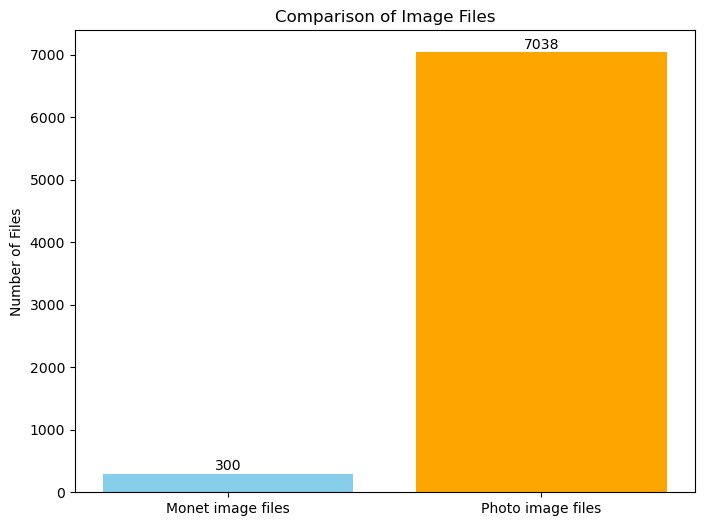

In [5]:

def count(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

monet_count = count(MONET_FILENAMES)  
photo_count = count(PHOTO_FILENAMES)  
print(f'Monet image files: {monet_count}')
print(f'Photo image files: {photo_count}')

categories = ['Monet image files', 'Photo image files']
values = [monet_count, photo_count]


plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'orange'])


plt.title('Comparison of Image Files')
plt.ylabel('Number of Files')


for i in range(len(categories)):
    plt.text(i, values[i] + 5, str(values[i]), ha='center', va='bottom')


plt.show()

Load TFRecord to Image

In [6]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 2
EPOCHS =25
IMG_COUNT =300

def tfrec2image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 #[-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tfrec2image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


monet_data = load_dataset(MONET_FILENAMES)
photo_data = load_dataset(PHOTO_FILENAMES)


Check the shape of one batch of images from both the Monet-style image dataset and the photo image dataset.

Shape of a batch of images: (2, 256, 256, 3)
Shape of a batch of images: (2, 256, 256, 3)


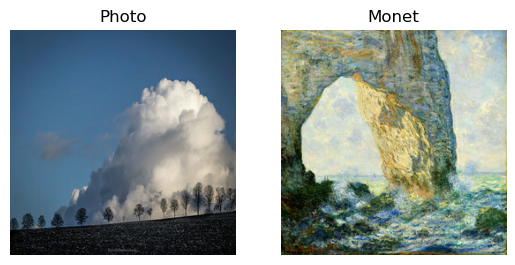

In [7]:
#[-1,1] ---> [0,255]
def inverse_img(image):
    return ((image + 1) * 127.5).astype(np.uint8)


def view_example_image(monet_data,photo_data, num_examples=1):
   
    for batch_photo_images in photo_data.take(num_examples):  
        print("Shape of a batch of images:", batch_photo_images.shape)
    for batch_monet_images in monet_data.take(num_examples):  
        print("Shape of a batch of images:", batch_monet_images.shape)
        
    plt.subplot(1,2,1)
    plt.title('Photo')
    plt.imshow(inverse_img(batch_photo_images[0].numpy()))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Monet')
    plt.imshow(inverse_img(batch_monet_images[0].numpy()))
    plt.axis('off')

    plt.show()
    
view_example_image(monet_data,photo_data, num_examples=1)

### Histogram was drawn to compare the distribution of pixel values

In [8]:



def extract_images(dataset, num_batches=1):
    images = []
    for batch in dataset.take(num_batches):
        images.extend(batch.numpy())
    return np.array(images)


monet_images = extract_images(monet_data, IMG_COUNT)
photo_images = extract_images(photo_data, IMG_COUNT)

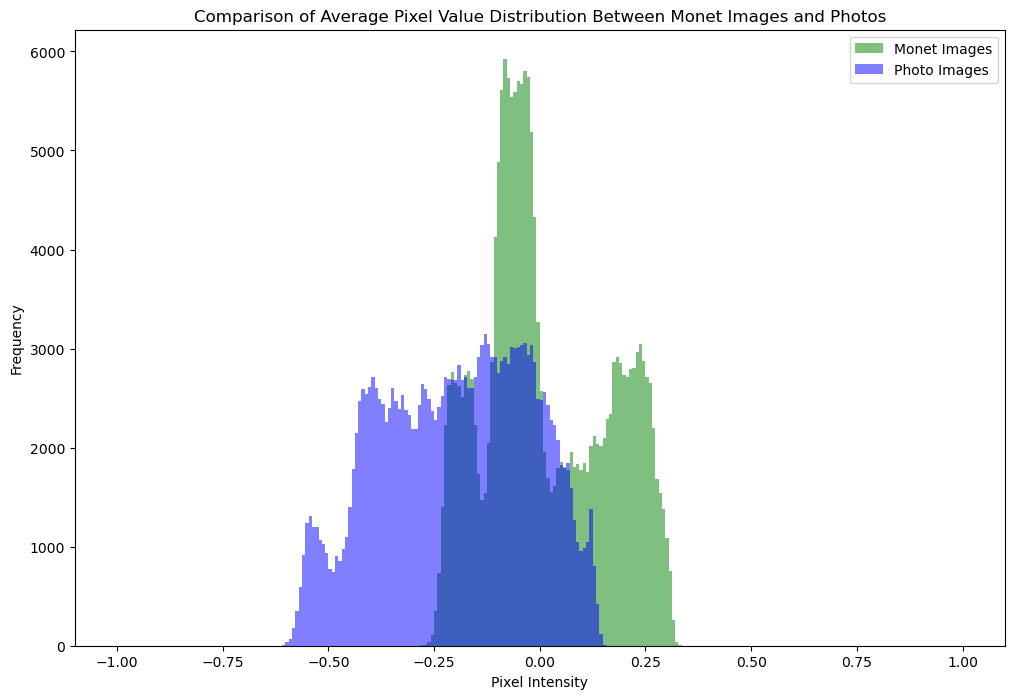

In [9]:

def view_pixelvalue_distribution(monet_images,photo_images):
    if len(monet_images) > 0 and len(photo_images) > 0:
        avg_pixel_distribution_group1 = np.mean(monet_images, axis=0).flatten()
        avg_pixel_distribution_group2 = np.mean(photo_images, axis=0).flatten()

        plt.figure(figsize=(12, 8))
        plt.hist(avg_pixel_distribution_group1, bins=256, range=(-1, 1), alpha=0.5, label='Monet Images', color='green')
        plt.hist(avg_pixel_distribution_group2, bins=256, range=(-1, 1), alpha=0.5, label='Photo Images', color='blue')


        plt.title('Comparison of Average Pixel Value Distribution Between Monet Images and Photos')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

    
        plt.legend(loc='upper right')
        plt.show()
    else:
        print("One or both datasets do not contain any images.")
        
        
view_pixelvalue_distribution(monet_images,photo_images)

The average pixel intensity of Monet style images is slightly higher than that of photographs, which may reflect the use of more bright, muted colors in Monet paintings, while photographs may more realistically reflect natural light and shadow contrasts.

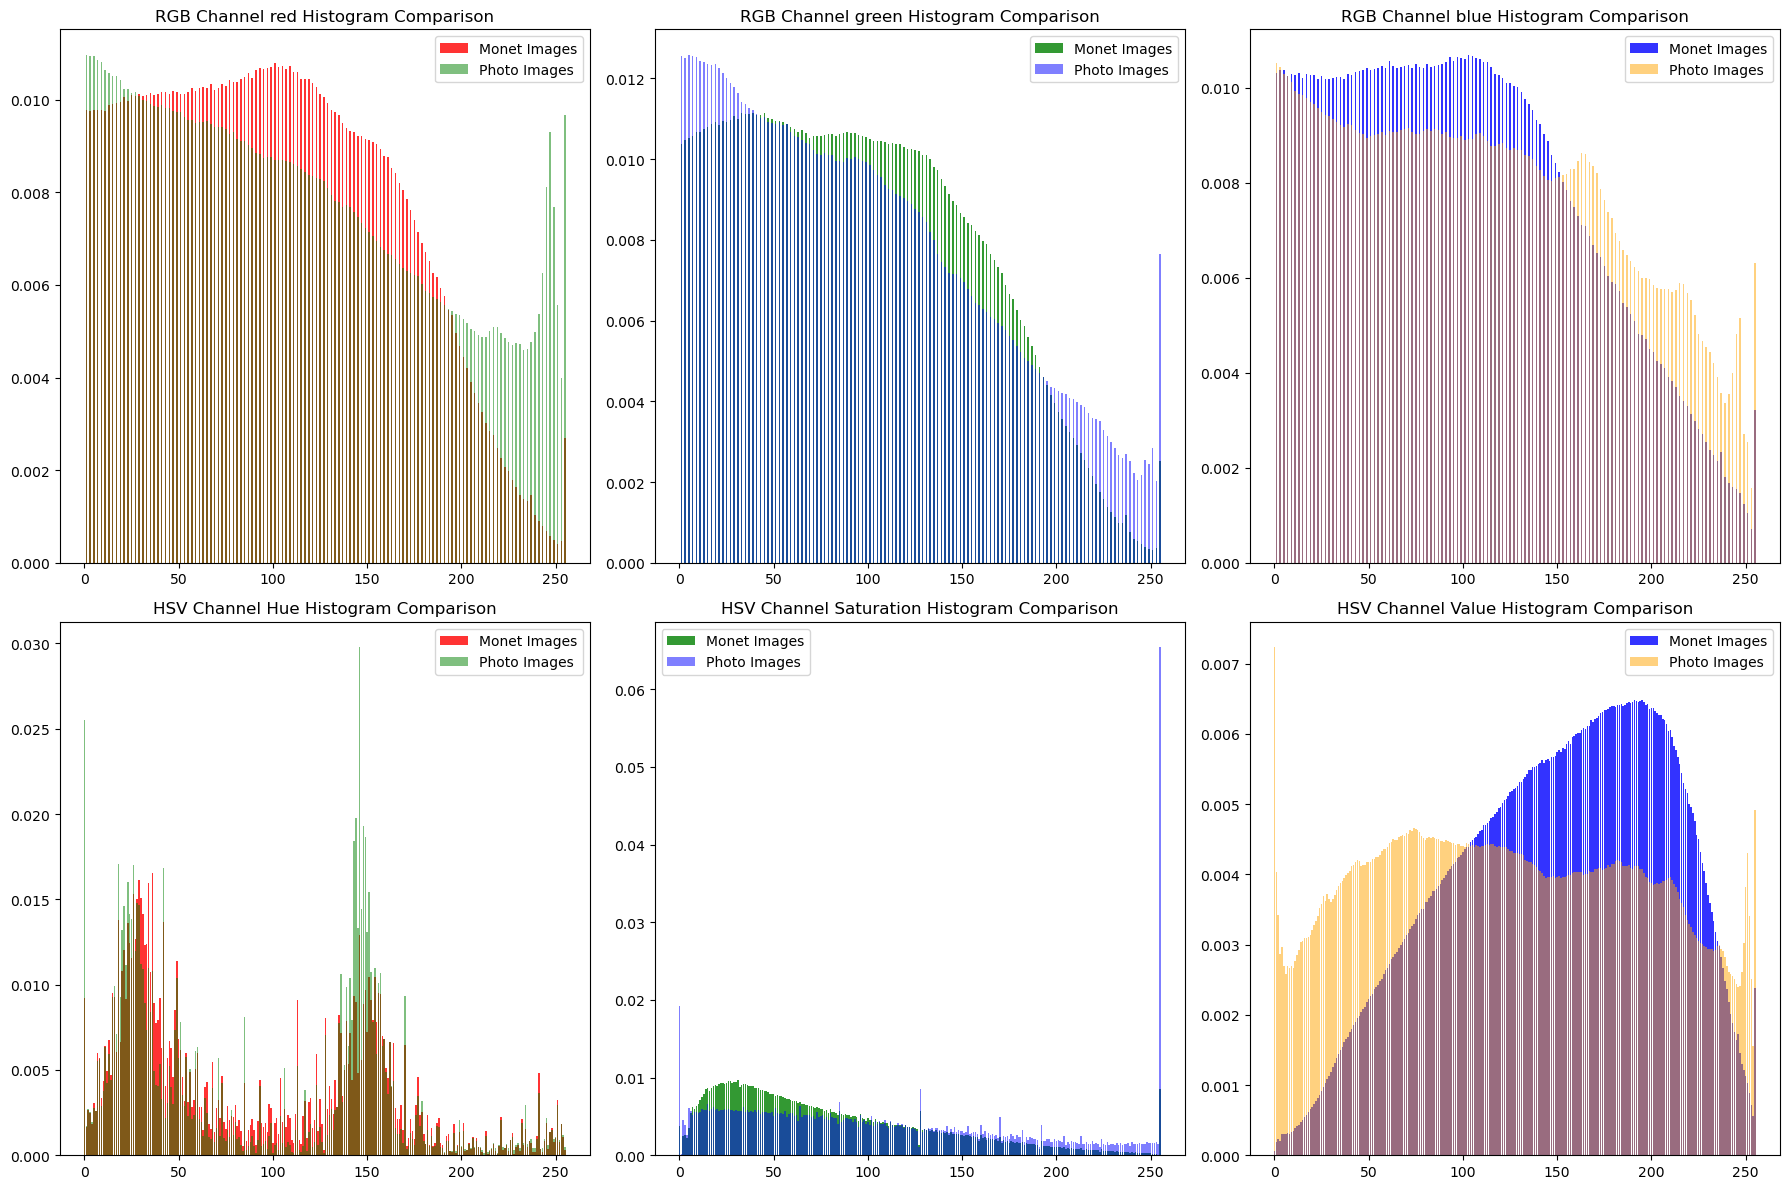

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


def normalize_images(images):
    """Normalize images from [-1, 1] to [0, 1]."""
    return (images + 1.0) / 2.0

def rgb_to_hsv(images):
    """
    Convert a batch of RGB images with pixel values in the range [-1, 1] 
    to HSV color space.
    """
    # Normalize images from [-1, 1] to [0, 1]
    normalized_images = normalize_images(images)
    # Ensure data type is float32 for accurate conversion
    normalized_images = tf.cast(normalized_images, dtype=tf.float32)
    images_hsv = tf.image.rgb_to_hsv(normalized_images)
    return images_hsv.numpy()


def compute_histogram(image, bins=256, range=(0, 1)):
    hist_r = np.histogram(image[:, :, 0].flatten(), bins=bins, range=range)[0]
    hist_g = np.histogram(image[:, :, 1].flatten(), bins=bins, range=range)[0]
    hist_b = np.histogram(image[:, :, 2].flatten(), bins=bins, range=range)[0]
    return hist_r, hist_g, hist_b
def normalize_histogram(hist):
    # Normalize histogram so that it sums to 1
    total = np.sum(hist)
    if total > 0:
        return hist / total
    else:
        return hist

def compute_average_histogram(images, color_space='rgb'):
    if color_space.lower() == 'hsv':
        images = rgb_to_hsv(images)
    
    histograms = [compute_histogram(image) for image in images]
    avg_hist_r = np.mean([hist[0] for hist in histograms], axis=0)
    avg_hist_g = np.mean([hist[1] for hist in histograms], axis=0)
    avg_hist_b = np.mean([hist[2] for hist in histograms], axis=0)
    
    # Normalize the histogram so that it sums to 1
    avg_hist_r = normalize_histogram(avg_hist_r)
    avg_hist_g = normalize_histogram(avg_hist_g)
    avg_hist_b = normalize_histogram(avg_hist_b)
    
    return avg_hist_r, avg_hist_g, avg_hist_b



def view_rgb_hsv(monet_images,photo_images):
    avg_hist_group1_rgb = compute_average_histogram(monet_images, color_space='rgb')
    avg_hist_group2_rgb = compute_average_histogram(photo_images, color_space='rgb')

    avg_hist_group1_hsv = compute_average_histogram(monet_images, color_space='hsv')
    avg_hist_group2_hsv = compute_average_histogram(photo_images, color_space='hsv')

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))


    colors = ['red', 'green', 'blue','orange']
    hsv = ['Hue', 'Saturation', 'Value']
    #  RGB 
    for i, ax in enumerate(axes[0]):
        ax.bar(range(256), avg_hist_group1_rgb[i], color=colors[i], alpha=0.8, label='Monet Images')
        ax.bar(range(256), avg_hist_group2_rgb[i], color=colors[i+1], alpha=0.5, label='Photo Images')
        ax.set_title(f'RGB Channel {colors[i]} Histogram Comparison')
        ax.legend()

    #  HSV 
    for i, ax in enumerate(axes[1]):
        ax.bar(range(256), avg_hist_group1_hsv[i], color=colors[i], alpha=0.8, label='Monet Images')
        ax.bar(range(256), avg_hist_group2_hsv[i], color=colors[i+1], alpha=0.5, label='Photo Images')
        ax.set_title(f'HSV Channel {hsv[i]} Histogram Comparison')
        ax.legend()

    plt.tight_layout()
    plt.show()
    
    
view_rgb_hsv(monet_images,photo_images)

The red distribution of Monet images is more concentrated, especially in the medium and high intensity (150-250) range.Moreover, the green distribution increased significantly in the high-intensity portion (200-250).Monet style images have a greater proportion of higher saturation, which means that their colors are more vibrant.

The Monet style tends to favor bright, high-saturation, high-brightness colors.

In [11]:




def calculate_statistics(image, color_space='rgb'):
    if color_space.lower() == 'hsv':
        hsv = rgb_to_hsv(image)
        saturation = np.mean(hsv[:, :, 1])  # average saturation
    else:
        saturation = None
    
    gray = color.rgb2gray(image)  # convert to grayscale to calculate brightness and contrast
    brightness = np.mean(gray)  # Average brightness
    contrast = np.std(gray)  # Contrast, here represented by standard deviation

    return {'brightness': brightness, 'contrast': contrast, 'saturation': saturation}

def compare_statistics(monet_images, photo_images, color_space='rgb'):
    stats_group1 = [calculate_statistics(img, color_space) for img in monet_images]
    stats_group2 = [calculate_statistics(img, color_space) for img in photo_images]

    avg_brightness_g1 = np.mean([s['brightness'] for s in stats_group1])
    avg_contrast_g1 = np.mean([s['contrast'] for s in stats_group1])
    avg_saturation_g1 = np.mean([s['saturation'] for s in stats_group1 if s['saturation'] is not None])

    avg_brightness_g2 = np.mean([s['brightness'] for s in stats_group2])
    avg_contrast_g2 = np.mean([s['contrast'] for s in stats_group2])
    avg_saturation_g2 = np.mean([s['saturation'] for s in stats_group2 if s['saturation'] is not None])

    print(f"Monet: Average Brightness={avg_brightness_g1:.2f}, Contrast={avg_contrast_g1:.2f}, Saturation={avg_saturation_g1:.2f}")
    print(f"Photo: Average Brightness={avg_brightness_g2:.2f}, Contrast={avg_contrast_g2:.2f}, Saturation={avg_saturation_g2:.2f}")




# Compare the statistics of the two sets of images
compare_statistics(monet_images, photo_images, color_space='hsv')

Monet: Average Brightness=0.04, Contrast=0.36, Saturation=0.31
Photo: Average Brightness=-0.18, Contrast=0.40, Saturation=0.42


The brightness of the Monet style image is close to neutral (0.00), indicating that the overall tone is bright and there are no significant dark or overlit areas.The lower contrast in Monet's paintings means that the transitions between color and light and dark are smoother. This characteristic is consistent with the soft brush strokes and light effects of Impressionist paintings.The saturation of Monet's paintings is slightly lower, indicating that the colors, while vibrant, are not overly intense.

### Augment data
We set up data augmentation pipelines within a distributed strategy scope for the monet_data and photo_data datasets, including repeating the datasets, applying an augmentation function, and performing random left-right flips on images.


In [12]:
with strategy.scope():
    monet_data = monet_data.repeat()
    photo_data = photo_data.repeat()
        
    monet_data = monet_data.shuffle(2048)
    # photo_data = photo_data.shuffle(2048)

    def flip(image):
        return tf.image.random_flip_left_right(image)

    monet_data = monet_data.map(flip, num_parallel_calls=tf.data.AUTOTUNE)
    # photo_data = photo_data.map(flip, num_parallel_calls=tf.data.AUTOTUNE)
    



Utilizing differentiable image augmentations such as color adjustments, translations, and cutouts.

In [13]:
with strategy.scope():
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738
# from https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py



    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x


    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 2.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x


    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x
        


    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
        }
    
    def aug_fn(image):
        return DiffAugment(image,"color")
    
    def normalize_image(image):
        min_val = np.min(image)
        max_val = np.max(image)
        return (image - min_val) / (max_val - min_val)
    
    def standardize_image_tensor(image):
        mean = tf.reduce_mean(image)
        std = tf.math.reduce_std(image)
        return (image - mean) / std
    
    def clip_and_normalize_image_tensor(image, low=-0.5, high=0.5):
        clipped_image = tf.clip_by_value(image, low, high)
        return (clipped_image - low) / (high - low)
    
  
    
    def random_augment_photo(x):
 
        brightness_range = (0.18, 0.25)  # 根据实际情况调整范围
        # 随机增加亮度
        brightness_increase = tf.random.uniform([], minval=brightness_range[0], maxval=brightness_range[1])
        x = tf.image.adjust_brightness(x, delta=brightness_increase)
        # 减少饱和度
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2 *0.7
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
    
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 8.0e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

In [14]:
with strategy.scope():
    monet_data = monet_data.map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
    photo_data = photo_data.map(random_augment_photo, num_parallel_calls=tf.data.AUTOTUNE)


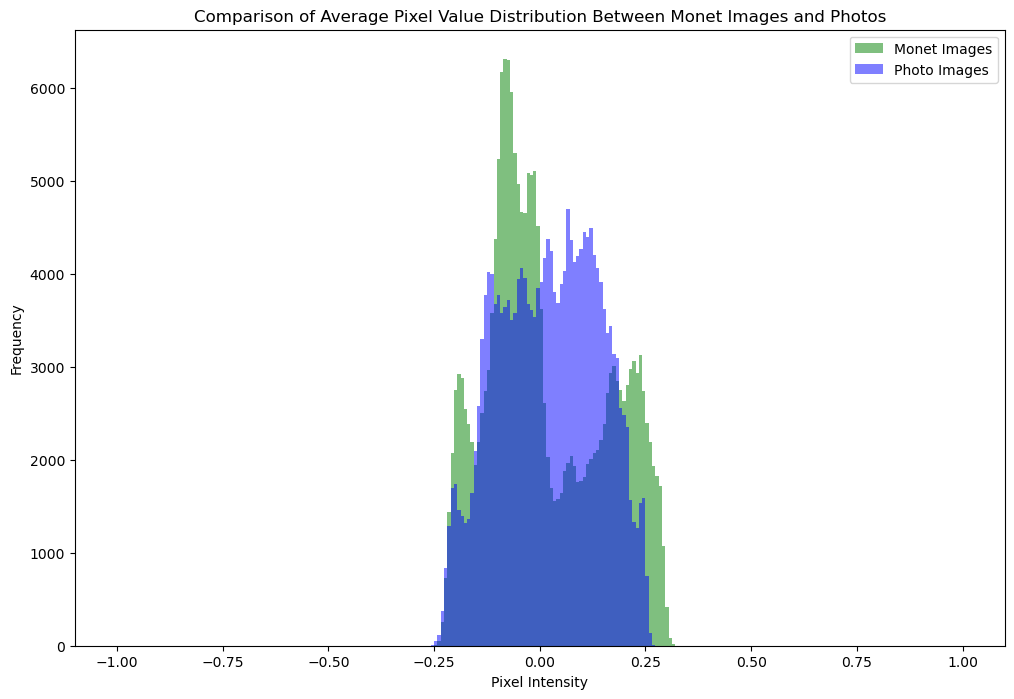

In [15]:


monet_images = extract_images(monet_data, IMG_COUNT)
photo_images = extract_images(photo_data, IMG_COUNT)


view_pixelvalue_distribution(monet_images,photo_images)

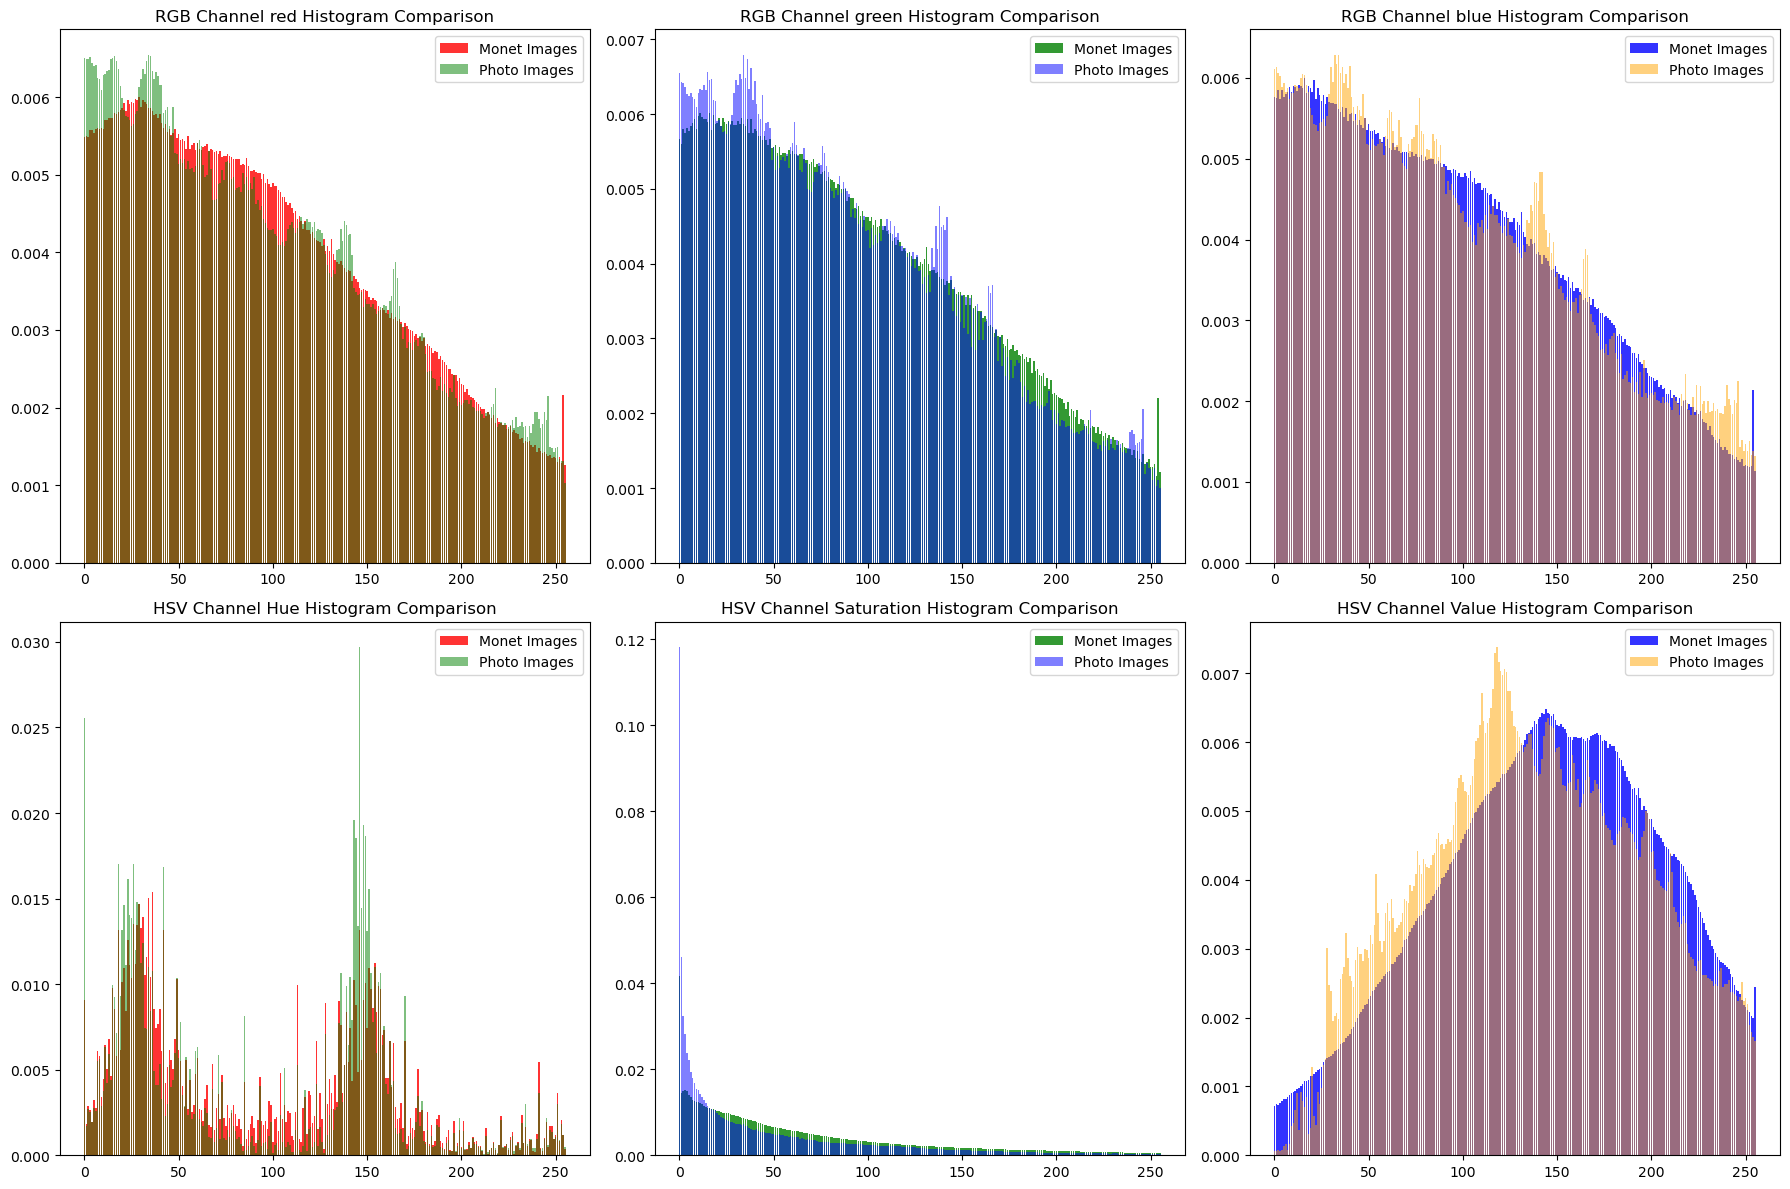

In [16]:

view_rgb_hsv(monet_images,photo_images)

In [17]:
compare_statistics(monet_images, photo_images, color_space='hsv')

Monet: Average Brightness=0.04, Contrast=0.36, Saturation=0.48
Photo: Average Brightness=0.03, Contrast=0.28, Saturation=0.20


### View Photo and Monet image

Let's visualize a photo example and a Monet example.

Visualizing the processed images by displaying a photo image and a Monet-style image side-by-side after normalizing their pixel values for proper display.

Shape of a batch of images: (2, 256, 256, 3)
Shape of a batch of images: (2, 256, 256, 3)


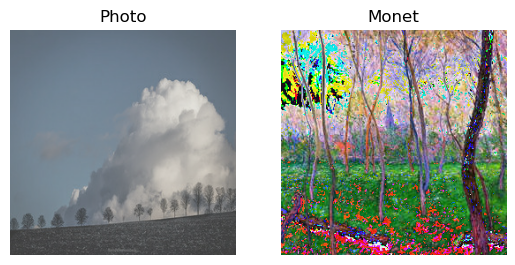

In [18]:
view_example_image(monet_data,photo_data, num_examples=1)

### Build the generator

The process of down-sampling and up-sampling enables deep learning models to extract and recover features efficiently, while reducing computational complexity and enhancing the model's ability to process features at different scales.

Downsampling:
Each layer continues to use a 4x4 convolution kernel with a step size of 2, gradually reducing the space size and increasing the number of channels until the final layer reaches the maximum number of channels of 512

In [19]:

class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer="ones",
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.scale * (inputs - mean) / tf.sqrt(variance + self.epsilon) + self.offset

# filter-The number of filters in the Conv2D layer is the number of output feature maps
# size -Convolution kernel size
def Cov2d(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        instance_norm_layer = InstanceNormalization()
        result.add(instance_norm_layer)
    result.add(layers.LeakyReLU())
    return result


def deCov2d(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    instance_norm_layer = InstanceNormalization()
    result.add(instance_norm_layer)
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

In [20]:
from tensorflow.keras.layers import  Conv2D, Conv2DTranspose, BatchNormalization, Add, Lambda


def residual_block(x, filters, kernel_size=3, strides=1, dilation_rate=1, use_bias=False,):
    shortcut = x
    initializer = tf.random_normal_initializer(0., 0.02)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', 
               dilation_rate=dilation_rate,
               kernel_initializer=initializer,
               use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same',
               dilation_rate=dilation_rate,
               kernel_initializer=initializer,
               use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

def Generator():
    inputs =  layers.Input(shape=[256, 256, 3])
    
    Downsampling =[
        Cov2d(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        Cov2d(128, 4), # (bs, 64, 64, 128)
        Cov2d(256, 4), # (bs, 32, 32, 256)
        Cov2d(512, 4), # (bs, 16, 16, 512)
        Cov2d(512, 4), # (bs, 8, 8, 512)
        Cov2d(512, 4), # (bs, 4, 4, 512)
        Cov2d(512, 4), # (bs, 2, 2, 512)
        Cov2d(512, 4), # (bs, 1, 1, 512)
    ]
    
    Upsampling = [
        deCov2d(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        deCov2d(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        deCov2d(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        deCov2d(512, 4), # (bs, 16, 16, 1024)
        deCov2d(256, 4), # (bs, 32, 32, 512)
        deCov2d(128, 4), # (bs, 64, 64, 256)
        deCov2d(64, 4), # (bs, 128, 128, 128)
    ]
    

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    
    skips = []
    for down in Downsampling:
        x = down(x)
        # x = residual_block(x, x.shape[-1])  # Apply a residual block after each Downsampling step
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(Upsampling, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

### Build the discriminator

The discriminator receives the input image and classifies it as real or false . Rather than output a single node, the discriminator outputs a smaller 2D image where a higher pixel value represents a true classification and a lower pixel value represents a false classification.

In [21]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape=[256, 256, 3])  #  256x256，3 （RGB）

  
    encoder_stack = [
        Cov2d(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        Cov2d(128, 4),  # (bs, 64, 64, 128)
        Cov2d(256, 4),  # (bs, 32, 32, 256)
        # Cov2d(512, 4),  # (bs, 16, 16, 512)
    ]

    
    x = inputs

  
    for down in encoder_stack:
        x = down(x)

    zero_pad1 = layers.ZeroPadding2D()(x)  #  (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  #  (bs, 31, 31, 512)
    instance_norm_layer = InstanceNormalization()
    norm1 = instance_norm_layer(conv)  
    leaky_relu = layers.LeakyReLU()(norm1) 

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  #  (bs, 30, 30, 1)
    # Test Code
    # last = layers.Conv2D(1, 4, strides=1,
    #                      kernel_initializer=initializer)(x)#(bs, 13, 13, 1)
    
    return Model(inputs=inputs, outputs=last)  

In [22]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

### View feature extraction and dimensionality reduction

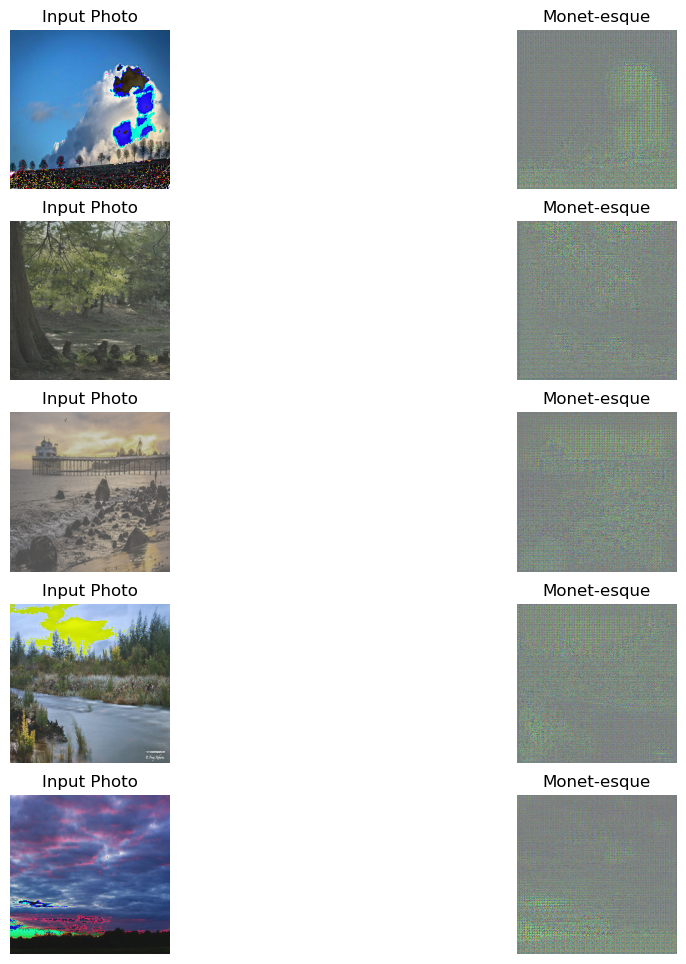

In [23]:


def  View_img2monet(count):
    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i, img in enumerate(photo_data.take(count)):
        prediction = monet_generator(img, training=False)[0].numpy()
        
        img = inverse_img(img[0].numpy())
        prediction =inverse_img(prediction)
        
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()



View_img2monet(5)

### CycleGAN model

By learning the mapping relationship between two different domains, CycleGAN can transform image styles without using paired training data.

We will inherit a tf.keras.Model to run fit () later to train our model. In the training step, the model converts the photo into a Monet painting and then back to the photo. The difference between the original photo and the photo that has been transformed twice is cyclic consistency loss.

In [24]:
# Setting up the new GAN model

class CycleGAN(Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, 
                 lambda_cycle=10,gamma_loss=1e-4, lambda_id_loss=1e-5, **kwargs):
        super(CycleGAN, self).__init__(**kwargs)
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.gamma_loss = gamma_loss
        self.lambda_id_loss = lambda_id_loss
        self.d_loss_arr = []
        self.g_loss_arr = []
        self.discriminator_features_monet = Model(
                                            inputs=self.m_disc.input,
                                            outputs=self.m_disc.layers[-2].output
                                            )
        self.discriminator_features_photo = Model(
                                            inputs=self.p_disc.input,
                                            outputs=self.p_disc.layers[-2].output
                                            )

        
        

    def get_config(self):
        config = super().get_config()
        config.update({
            "lambda_cycle": self.lambda_cycle,
            "gamma_loss": self.gamma_loss,
            "lambda_id_loss": self.lambda_id_loss
        })
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        # Create a new instance with the given configuration
        model_instance = cls(
            monet_generator=None,  # These will be set after loading weights
            photo_generator=None,
            monet_discriminator=None,
            photo_discriminator=None,
            lambda_cycle=config.get("lambda_cycle", 10),
            gamma_loss=config.get("gamma_loss", 1e-4),
            lambda_id_loss=config.get("lambda_id_loss", 1e-5)
        )
        
        return model_instance

    def save_weights_separately(self, base_path):
        # Save weights of each sub-model to separate files
        m_gen_weights_path = f"{base_path}_m_gen.weights.h5"
        p_gen_weights_path = f"{base_path}_p_gen.weights.h5"
        m_disc_weights_path = f"{base_path}_m_disc.weights.h5"
        p_disc_weights_path = f"{base_path}_p_disc.weights.h5"
        print('path',m_gen_weights_path)
        self.m_gen.save_weights(m_gen_weights_path)
        self.p_gen.save_weights(p_gen_weights_path)
        self.m_disc.save_weights(m_disc_weights_path)
        self.p_disc.save_weights(p_disc_weights_path)

    @classmethod
    def load_weights_separately(cls, base_path, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10,gamma_loss=1e-4, lambda_id_loss=1e-5):
        # Load weights into each sub-model
        m_gen_weights_path = f"{base_path}_m_gen.weights.h5"
        p_gen_weights_path = f"{base_path}_p_gen.weights.h5"
        m_disc_weights_path = f"{base_path}_m_disc.weights.h5"
        p_disc_weights_path = f"{base_path}_p_disc.weights.h5"

        monet_generator.load_weights(m_gen_weights_path)
        photo_generator.load_weights(p_gen_weights_path)
        monet_discriminator.load_weights(m_disc_weights_path)
        photo_discriminator.load_weights(p_disc_weights_path)

        # Initialize and return the CycleGAN instance with loaded weights
        return cls(
            monet_generator=monet_generator,
            photo_generator=photo_generator,
            monet_discriminator=monet_discriminator,
            photo_discriminator=photo_discriminator,
            lambda_cycle=lambda_cycle,
            gamma_loss=gamma_loss,
            lambda_id_loss=lambda_id_loss
        )

      
    
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        # print(batch_data)
        real_monet, real_photo = batch_data
        # print("Real Monet shape:", real_monet.shape)
        # print("Real Photo shape:", real_photo.shape)
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Using discriminator to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            disc_feat_monet = self.discriminator_features_monet(real_monet, training=True)
            disc_feat_cycled_monet = self.discriminator_features_monet(cycled_monet, training=True)
            
            disc_feat_photo = self.discriminator_features_photo(real_photo, training=True)
            disc_feat_cycled_photo = self.discriminator_features_photo(cycled_photo, training=True)
            
            # evaluates total cycle consistency loss
            cycle_loss_x = ((1 - self.gamma_loss) * self.cycle_loss_fn(real_monet, cycled_monet,self.lambda_cycle) +
                    self.gamma_loss * self.cycle_loss_fn(disc_feat_monet, disc_feat_cycled_monet,self.lambda_cycle))
            cycle_loss_y = ((1 - self.gamma_loss) * self.cycle_loss_fn(real_photo, cycled_photo,self.lambda_cycle) +
                    self.gamma_loss * self.cycle_loss_fn(disc_feat_photo, disc_feat_cycled_photo,self.lambda_cycle))
            total_cycle_loss = (cycle_loss_x + cycle_loss_y)

        
            # total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.lambda_id_loss *self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.lambda_id_loss *self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
      
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        self.g_loss_arr.append(total_monet_gen_loss + total_photo_gen_loss)
        self.d_loss_arr.append(monet_disc_loss + photo_disc_loss)
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [25]:
#它的主要作用是在每个 epoch 结束时计算 FID 并输出结果。从直接影响训练的角度来看，FIDCallback 主要是用于监控和评估生成模型的质量，而不是直接改变训练流程
class FIDCalculator(object):
    def __init__(self, images_x_ds, images_y_ds, model_generator, fid_model_base):
        self.images_x_ds = images_x_ds
        self.images_y_ds = images_y_ds
        self.model_generator = model_generator
        self.fid_model_base = fid_model_base
        self.initialized = False
        self.history = []

    def init_stat_x(self):
        self.mu_2, self.sigma_2 = self._calculate_activation_statistics_mod(self.images_y_ds, self.fid_model_base)
        self.initialized = True

    def _calculate_activation_statistics_mod(self, images, fid_model):
        act = tf.cast(fid_model.predict(images, verbose=0), tf.float32)
        mu = tf.reduce_mean(act, axis=0)
        mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
        mx = tf.matmul(tf.transpose(mean_x), mean_x)
        vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
        sigma = vx - mx
        return mu, sigma

    def _calculate_frechet_distance(self, mu_1, sigma_1, mu_2, sigma_2):
        fid_epsilon = 1e-14
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma_1, sigma_2), tf.complex64))
        covmean = tf.cast(tf.math.real(covmean), tf.float32)
        tr_covmean = tf.linalg.trace(covmean)
        fid_value = tf.matmul(
            tf.expand_dims(mu_1 - mu_2, axis=0),
            tf.expand_dims(mu_1 - mu_2, axis=1)
            ) + tf.linalg.trace(sigma_1) + tf.linalg.trace(sigma_2) - 2 * tr_covmean
        return fid_value

    def _get_gen_plus_fid_model(self):
        inputs = layers.Input(shape=[256, 256, 3], name='input_image')
        x = self.model_generator(inputs)
        outputs = self.fid_model_base(x)
        fid_model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return fid_model

    def calc_fid(self):
        if not self.initialized:
            self.init_stat_x()
        fid_model_plus = self._get_gen_plus_fid_model()
        mu_1, sigma_1 = self._calculate_activation_statistics_mod(self.images_x_ds, fid_model_plus)
        fid_value = self._calculate_frechet_distance(mu_1, sigma_1, self.mu_2, self.sigma_2)
        return fid_value

In [26]:
def create_fid_inception_model():
    inception_model_base = tf.keras.applications.InceptionV3(
        input_shape=(256,256,3),
        pooling="avg",
        include_top=False)
    mix3  = inception_model_base.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)
    inception_model = tf.keras.Model(inputs=inception_model_base.input, outputs=f0)
    inception_model.trainable = False
    return inception_model

In [27]:
from tensorflow.keras.callbacks import Callback
class FIDCallback(Callback):
    def __init__(self, fid_calculator, epoch_interval=None):
        self.fid_calculator = fid_calculator
        self.epoch_interval = epoch_interval

    def _get_fid(self):
        fid = self.fid_calculator.calc_fid()
        print("FID score:", fid.numpy()[0,0])

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            self._get_fid()

    def on_train_end(self, logs=None):
        self._get_fid()

In [28]:
from matplotlib.pyplot import subplots


class PlotPredictionsCallback(Callback):
    def __init__(self, input_image, model_generator, epoch_interval=None, nrows=1, figsize=(11, 11)):
        self.input_image = input_image
        self.model_generator = model_generator
        self.epoch_interval = epoch_interval
        self.nrows = nrows
        self.figsize=(11, 11)

    def _plot_test_and_pred(self):
        (fig, axes) = subplots(nrows=self.nrows, ncols=2, figsize=self.figsize)
        img = self.input_image
        if self.nrows == 1:
            axes = [axes]
        img_batch = np.expand_dims(img, axis=0)
        prediction = monet_generator(img_batch, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img * 127.5 + 127.5).numpy().astype(np.uint8)
        for  ax in axes:
            ax[0].imshow(img)
            ax[1].imshow(prediction)
            ax[0].set_title("Input Photo")
            ax[1].set_title("Monet-esque")
            ax[0].axis("off")
            ax[1].axis("off")
        plt.show()



    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            self._plot_test_and_pred()

    def on_train_end(self, logs=None):
        self._plot_test_and_pred()

In [29]:
class UpdateLearningRateCallback(Callback):
    def __init__(self, epochs_count, lr_start=5e-3, lr_end=5e-6):
        super().__init__()
        self.epoch_min = epochs_count // 2
        epochs_update_count = epochs_count - self.epoch_min
        self.lr_values = np.linspace(lr_start, lr_end, epochs_update_count)

    def _scheduler_fn(self, epoch, lr):
        if epoch < self.epoch_min:
            return lr
        else:
            return self.lr_values[epoch-self.epoch_min]

    def on_epoch_begin(self, epoch, logs=None):
        self.model.m_gen_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.m_gen_optimizer.learning_rate)
        self.model.m_disc_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.m_disc_optimizer.learning_rate)
        self.model.p_gen_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.p_gen_optimizer.learning_rate)
        self.model.p_disc_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.p_disc_optimizer.learning_rate)

In [30]:
class UpdateLossWeightsCallback(Callback):
    def __init__(self, epochs, lambda_start=10, lambda_end=1e-4, gamma_start=1e-4, gamma_end=0.999):
        super().__init__()
        self.epochs = epochs
        self.lambda_start = lambda_start
        self.lambda_end = lambda_end
        self.gamma_start = gamma_start
        self.gamma_end = gamma_end

    def on_train_begin(self, logs=None):
        self.lambda_values = np.linspace(self.lambda_start, self.lambda_end, self.epochs)
        self.gamma_values = np.linspace(self.gamma_start, self.gamma_end, self.epochs)

    def on_epoch_begin(self, epoch, logs=None):
        self.model.lambda_cycle = self.lambda_values[epoch]
        self.model.gamma_loss = self.gamma_values[epoch]

### Defined loss function
The discriminator loss function below compares the real image to a matrix of 1 and the fake image to a matrix of 0. A perfect discriminator will output all 1s for the real image and all 0s for the fake image. The discriminator loss outputs the average of the actual loss and the generated loss.

In [31]:
with strategy.scope():
    def discriminator_loss(real, generated):
        #The output of the real image should be close to 1 ( considered real)
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        real_loss = tf.reduce_mean(real_loss)
        #The output of the generated image should be close to 0 ( considered fake)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        generated_loss = tf.reduce_mean(generated_loss)
        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

 Compute the generator loss using binary cross-entropy, comparing the discriminator's output for generated images against a target of ones to encourage the generator to produce more realistic images.

In [32]:
with strategy.scope():
       
    def generator_loss(generated):
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        loss = tf.reduce_mean(loss)
        return loss

Computes the cyclic consistency loss, which quantifies how closely a real image matches its twice-transformed version (cycled image), weighted by a factor LAMBDA to balance its significance against other losses.

In [33]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

Computes the identity loss, which evaluates the difference between a real image and its unchanged (identity-mapped) version, weighted by LAMBDA×0.5 to adjust its impact on the overall loss.

In [34]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))
    

In [35]:
EPOCH_INTERVAL =10
LAMBDA_START = 10
LAMBDA_END = 1e-4
GAMMA_START = 1e-4
GAMMA_END = 0.999
LAMBDA_ID = 1e-4
LR_START = 5e-3
LR_END = 2e-6

Set up Adam optimizers within a distributed strategy scope for training both generator and discriminator models of a GAN

In [36]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(LR_START, beta_1=0.7, 
    beta_2=0.999)
    photo_generator_optimizer = tf.keras.optimizers.Adam(LR_START, beta_1=0.7, 
    beta_2=0.999)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, 
    beta_2=0.999)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, 
    beta_2=0.999)

 Compile a CycleGAN model 

In [37]:
with strategy.scope():
    cycle_gan_model = CycleGAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [38]:

# with strategy.scope():
#     fid_model = create_fid_inception_model()
#     fid_calc = FIDCalculator(
#         images_x_ds=photo_data.take(300),
#         images_y_ds=monet_data,
#         model_generator=monet_generator,
#         fid_model_base=fid_model)
#     fid_calc.init_stat_x()
#     fid_cb = FIDCallback(fid_calculator=fid_calc, epoch_interval=EPOCH_INTERVAL)

In [39]:
with strategy.scope():
    first_img = next(iter(photo_data.take(1)))[0]
    plot_pred_cb = PlotPredictionsCallback(
        input_image=first_img,
        model_generator=monet_generator,
        epoch_interval=EPOCH_INTERVAL)

In [40]:
with strategy.scope():
    update_lr_cb = UpdateLearningRateCallback(EPOCHS, lr_start=LR_START, lr_end=LR_END)
    update_weights_cb = UpdateLossWeightsCallback(
        EPOCHS,
        lambda_start=LAMBDA_START,
        lambda_end=LAMBDA_END,
        gamma_start=GAMMA_START,
        gamma_end=GAMMA_END)

### Train model

In [41]:
with strategy.scope():
    if not LOAD_LOCALMODEL:
        history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)),
                            steps_per_epoch=(300//BATCH_SIZE),
                            epochs=EPOCHS,
                            callbacks=[plot_pred_cb,update_lr_cb,update_weights_cb],
                            verbose=2).history
        
        print('fit success')

In [42]:


def plot_training_history(history):
  
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # Helper function to compute the mean of each item in the list
    def compute_mean(loss_list):
        return [np.mean(item) if isinstance(item, (np.ndarray, tf.Tensor)) else item for item in loss_list]


    monet_gen_loss_avg = compute_mean(history['monet_gen_loss'])
    ax[0, 0].plot(monet_gen_loss_avg, label='Monet Generator Loss', marker='o')
    ax[0, 0].set_title('Monet Generator Loss Over Epochs')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].legend()
    ax[0, 0].grid(True)


    photo_gen_loss_avg = compute_mean(history['photo_gen_loss'])
    ax[0, 1].plot(photo_gen_loss_avg, label='Photo Generator Loss', marker='o')
    ax[0, 1].set_title('Photo Generator Loss Over Epochs')
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].legend()
    ax[0, 1].grid(True)


    monet_disc_loss_avg = compute_mean(history['monet_disc_loss'])
    ax[1, 0].plot(monet_disc_loss_avg, label='Monet Discriminator Loss', marker='o')
    ax[1, 0].set_title('Monet Discriminator Loss Over Epochs')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    photo_disc_loss_avg = compute_mean(history['photo_disc_loss'])
    ax[1, 1].plot(photo_disc_loss_avg, label='Photo Discriminator Loss', marker='o')
    ax[1, 1].set_title('Photo Discriminator Loss Over Epochs')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()
    ax[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

if not LOAD_LOCALMODEL:
     plot_training_history(history)

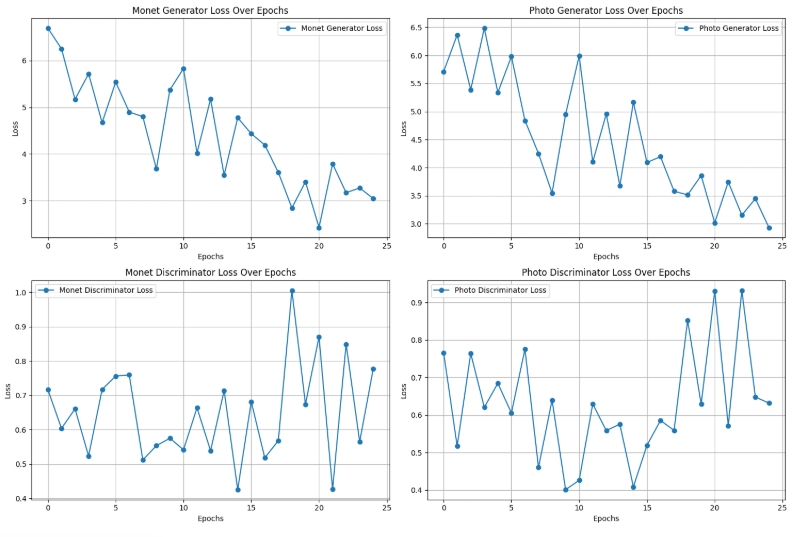

In [43]:
import shutil
import os

def create_folder(name,clearfile=False):
    path = OUT_PUT_PATH+name
    if(clearfile):
        print(path)
        if os.path.exists(path):
            shutil.rmtree(path)
            print(name,' Deletion complete')
        else:
            print(name,' Originally null')
            
    os.makedirs(name, exist_ok=True)

### Save Model weights 

In [44]:
if not LOAD_LOCALMODEL:
    create_folder('Model',False)

    with strategy.scope():
        cycle_gan_model.save_weights_separately( OUT_PUT_PATH+'Model/')

In [45]:
if  LOAD_LOCALMODEL:
    loaded_cycle_gan_model = CycleGAN.load_weights_separately(
        OUT_PUT_PATH+'Docker/Model/',
        monet_generator=monet_generator,
        photo_generator=photo_generator,
        monet_discriminator=monet_discriminator,
        photo_discriminator=photo_discriminator,
        lambda_cycle=10,
        gamma_loss=1e-4, 
        lambda_id_loss=1e-5
        
    )

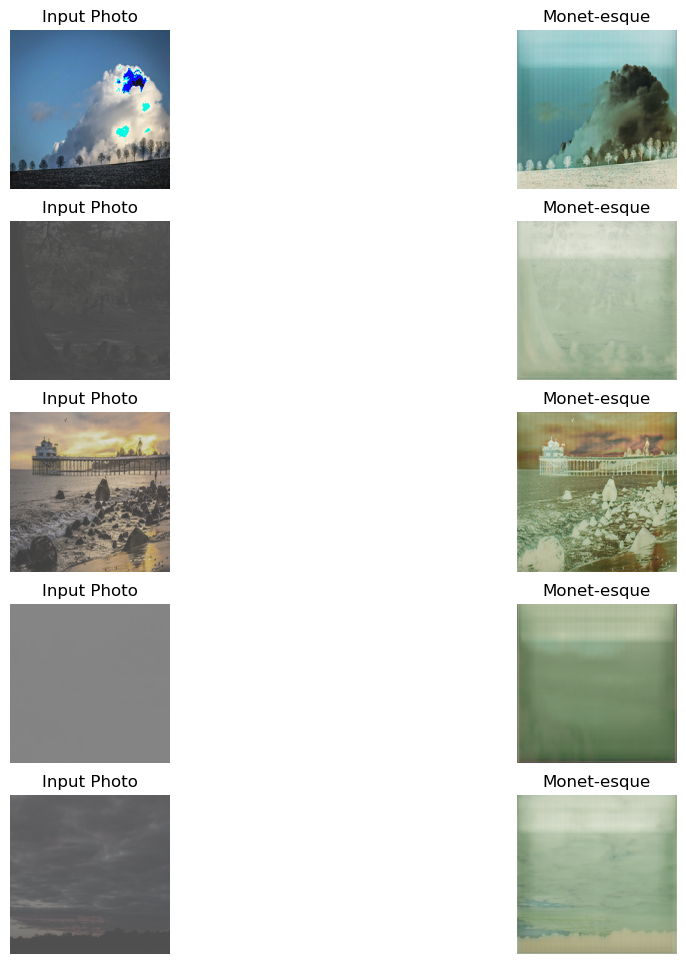

In [46]:



View_img2monet(5)

In [47]:
import os
from IPython.display import FileLink

if not LOAD_LOCALMODEL:
    os.chdir(OUT_PUT_PATH)
    folder_to_compress = 'Model'  
    output_tar_file = 'model_folder.tar.gz' 
   
    if not os.path.exists(folder_to_compress):
        print(f"Error: The folder '{folder_to_compress}' does not exist in the current directory.")
    else:
        !tar -czf {output_tar_file} {folder_to_compress}
        from IPython.display import FileLink
        display(FileLink(output_tar_file))

### Monet generator and Save images

In [48]:

create_folder('images',True)
i = 1
for img in photo_data:
    for batch in range(BATCH_SIZE):
        img_g=img[batch:batch+1]
        prediction = monet_generator(img_g, training=False)[0].numpy()
        prediction =inverse_img(prediction)
        # img_g = inverse_img(img_g[0].numpy())
        # print(img_g.shape)
        im = PIL.Image.fromarray(prediction)
        im.save("images/" + str(i) + ".jpg")
        i += 1
        if i %100 ==0:
            print(i)
    if i >= 9000: 
        break


print('generator success')


./images
images  Deletion complete
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500


KeyboardInterrupt: 

In [ ]:
import zipfile
import os

def zip_directory(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

zip_directory('/kaggle/working/images', '/kaggle/working/images.zip')

In [ ]:
print('completion of task')

### Training and Conclusion

* EPOCHS =25 
* LR =2e-4 
* augment data : Nothing

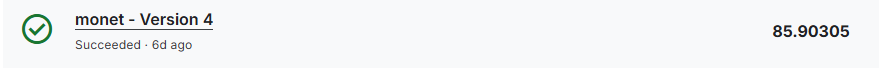


* EPOCHS =30
* LR =2e-4 
* augment data : Nothing 
  
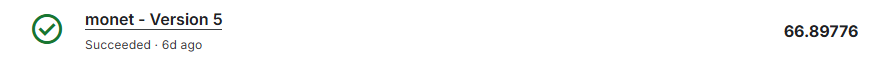

With the increase of epochs times, the model can recognize more features and train better

* EPOCHS =25
* LR =2e-4 
* augment data : repeat, shuffle, flip
  
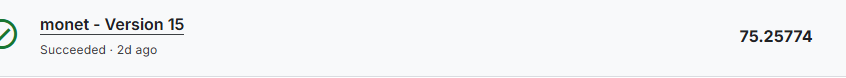

Augment data introduces more randomness, but the model learning gets worse

* EPOCHS =25
* LR =2e-4 
* augment data : Nothing

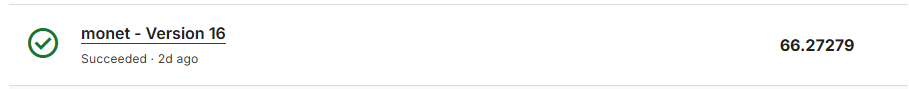

Cancel augment data, and we can find that the model performance is the same as before

* EPOCHS =25
* LR =2e-4 
* augment data : flip

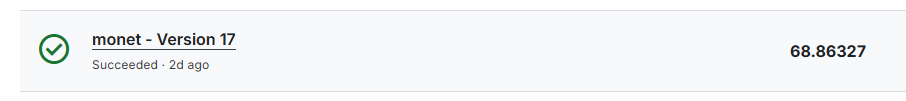

Flip only the image, it will not cause the model to deteriorate

* EPOCHS =25
* LR =2e-4 
* augment data : flip, Differentiable Augmentation (color\translation\cutout)

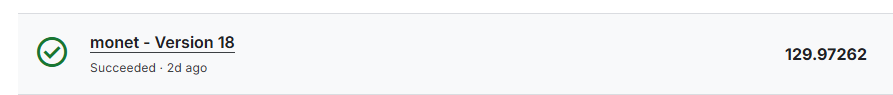

translation\cutout leads to too much loss of picture information and poor models

* EPOCHS =25
* LR =2e-4 
* augment data : flip, Differentiable Augmentation (color)
  
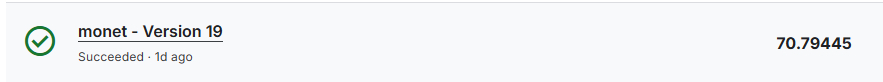

* EPOCHS =25
* LR =2e-3 
* augment data : flip, Differentiable Augmentation (color)

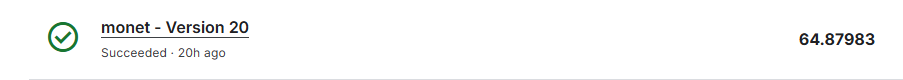


* EPOCHS =50
* LR =5e-3,beta_1=0.7
* augment data : flip, Differentiable Augmentation (color)
  
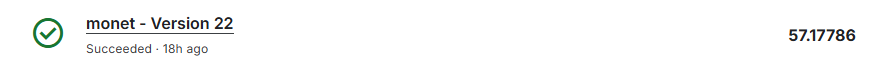


* EPOCHS =80
* LR =5e-3,beta_1=0.7
* augment data : flip, Differentiable Augmentation (color)
  
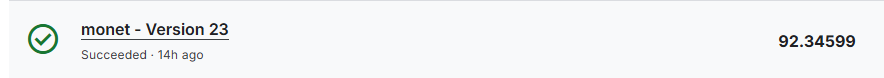

The model deteriorates after increasing EPOCHS, possibly because of overfitting